In [1]:
import requests 
import datetime as dt 
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM 
from tensorflow.keras import activations
from tensorflow.keras import layers
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

2023-09-29 16:52:34.370541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#snowbird 
#USS0011J42S  40.5600 -111.6600 2938.3 UT Snowbird  
#park city 
#US1UTSM0007  40.7455 -111.6095 2083.3 UT PARK CITY 8.7 NW  


### Data Variable Dictionary 

* tavg = average temperature 
* tmax = max temp 
* tmin = min temp 
* tobs = temperature at time of observation 
* snow = inches snowed that day --> this will be our outcome variable 
* prcp = precipitation (measured in inches)
* snwd = snow depth 
* wesd = water equivalent of snow on ground (depth of water that would cover the ground if snow was liquid)

In [3]:
#Quick visualiztion 
def read_in_data():
    return pd.read_csv('../data/alta_07.csv')
data = read_in_data()


In [4]:
def make_quick_viz():
    df = data[['DATE', 'PRCP', 
               'TMAX', 'TMIN', 'SNOW']]
    
    plt.title("Histogram of Daily Snow Fall Totals Inches")
    plt.hist(data['SNOW'])
    plt.show()
    print(" ")
    plt.title("Correlation between Snow, Precipitaiton, Max Temp, Min Temp")
    df_corr = df[['PRCP', 'SNOW', 
               'TMAX', 'TMIN']].corr()
    sns.heatmap(df_corr)
    plt.show()
    
    return df 

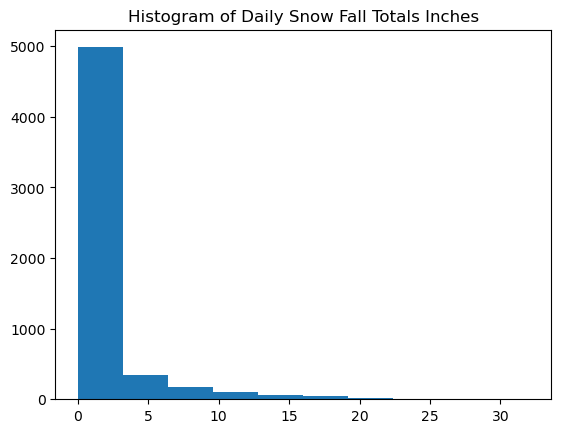

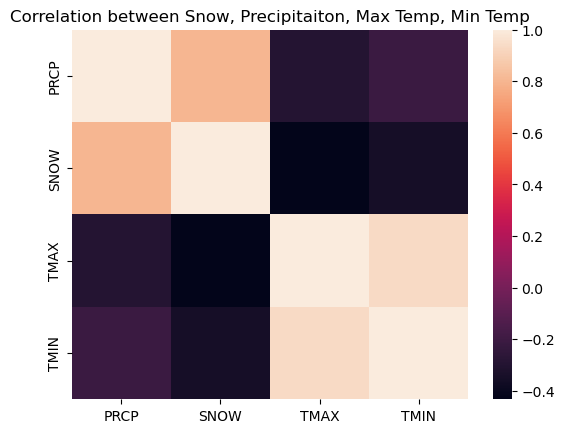

In [5]:
data2 = make_quick_viz()

As is the case with time series data, and as expected, there is a lot of cereal auto-correlation going on here. That presents some unique challenges when modeling because it essential means that we do not have any purely unique observations, we have like 5k observations, but none of those are truely independent except for perhasp the first. We will need to use non-linear methods to approximate this 

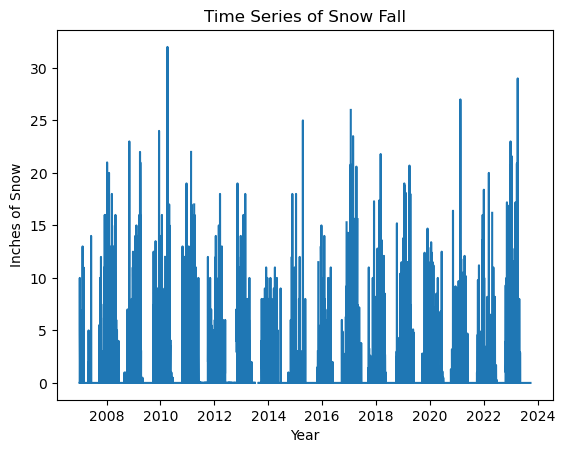

In [6]:
def convert_to_datetime(df):
    
    df['DATE'] = pd.to_datetime(df['DATE'])
    plt.title("Time Series of Snow Fall")
    plt.ylabel("Inches of Snow")
    plt.xlabel("Year")
    plt.plot(df['DATE'], df['SNOW'])
    plt.show()
    return df 
df = convert_to_datetime(data)

In [7]:
data2.isnull().sum()

DATE      0
PRCP    107
TMAX    138
TMIN    168
SNOW    214
dtype: int64

In [8]:
#got to view this null data 

n_df = data2.isnull().any(axis = 1)
null_rows = data2[n_df]

In [9]:
426/len(data2)

0.07165685449957948

In [10]:
def clean_null(df):
    
    
    df['DATE'] = pd.to_datetime(data2['DATE'])
    df['month'] = df['DATE'].apply(lambda x: x.month)
    df['day'] = df['DATE'].apply(lambda x: x.day)
    

    for col in df.columns.tolist():
        for i in range(len(df[col])):
            if str(df[col][i]) == 'nan':
                #subset = data2[(data2['month'] == 10) &(data2['day']==25)]
            
                df[col][i] = df[(df['month'] ==df['month'][i])&(df['day']==df['day'][i])][col].median()
            
            
    df = df.drop(columns = ['month', 'day'])       
    return df
    

In [11]:
data3 = clean_null(data2)

In [12]:
## Dont need to lag! 

In [13]:
def create_LSTM_data(df):
    
    #creating a copy
    df2 = df.copy()
    #setting index 
    df2.set_index("DATE", inplace = True)
    n_steps = [1]
    
    for col in df2.columns.tolist():
        for i in n_steps:
            df2[f'{col}_t_{i}'] = df2[col].shift(i)
    
    df2.dropna(inplace = True)
    #df2['output'] = df2.apply(lambda x: np.array([x['PRCP'], x['TMAX'], x['TMIN'], x['SNOW']]), axis = 1)
    return df2

In [14]:
data4 = create_LSTM_data(data3)
data4.head(3)

,PRCP,TMAX,TMIN,SNOW,PRCP_t_1,TMAX_t_1,TMIN_t_1,SNOW_t_1
DATE,,,,,,,,
2007-01-02,0.00,34.0,15.0,0.0,0.0,37.0,17.0,0.0
2007-01-03,0.00,42.0,23.0,0.0,0.0,34.0,15.0,0.0
2007-01-04,0.36,37.0,17.0,10.0,0.0,42.0,23.0,0.0


In [15]:
def split_data(df):
    
    df_c = df.reset_index()
    pre_data = df_c[pd.to_datetime(df_c['DATE']).dt.year <= 2011]
    post_data = df_c[pd.to_datetime(df_c['DATE']).dt.year >= 2011]
    
    pre_data.set_index("DATE", inplace = True)
    post_data.set_index("DATE", inplace = True)
    
    return pre_data, post_data

In [16]:
#pre_data, data5 = split_data(data4)

In [17]:
def create_output(matrix):
    scaled_df = pd.DataFrame(data = matrix, 
                columns = ['PRCP', 'TMAX', 'TMIN',
                          'SNOW', 'PRCP_t_1', 'TMAX_t_1', 'TMIN_t_1', 'SNOW_t_1'])
    
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df['PRCP'] = scaled_df['PRCP']/np.max(scaled_df['PRCP'])
    scaled_df['TMAX'] = scaler.fit_transform(np.array(scaled_df['TMAX']).reshape(len(scaled_df),1))
    scaled_df['TMIN'] = scaler.fit_transform(np.array(scaled_df['TMIN']).reshape(len(scaled_df),1))
    scaled_df['SNOW'] = scaled_df['SNOW']/np.max(scaled_df['SNOW'])
    scaled_df['PRCP_t_1'] = scaled_df['PRCP_t_1']/np.max(scaled_df['PRCP_t_1'])
    scaled_df['TMAX_t_1'] = scaler.fit_transform(np.array(scaled_df['TMAX_t_1']).reshape(len(scaled_df),1))
    scaled_df['TMIN_t_1'] = scaler.fit_transform(np.array(scaled_df['TMIN_t_1']).reshape(len(scaled_df),1))
    scaled_df['SNOW_t_1'] = scaled_df['SNOW_t_1']/np.max(scaled_df['SNOW_t_1'])

    scaled_df['output'] = scaled_df.apply(lambda x: np.array([x['PRCP'],
                                                              x['TMAX'], 
                                                              x['TMIN'],
                                                              x['SNOW']],
                                                               ), axis = 1)
    scaled_df['output'] = scaled_df['output']
    scaled_df = scaled_df.drop(columns = ['PRCP', 'TMAX', 'TMIN',
                          'SNOW'])
    return scaled_df,scaler

In [18]:
scaled_df,scaler = create_output(data4)

In [19]:
scaled_df

,PRCP_t_1,TMAX_t_1,TMIN_t_1,SNOW_t_1,output
DATE,,,,,
2007-01-02,0.000000,0.439024,0.407407,0.00000,"[0.0, 0.4024390243902439, 0.38271604938271603,..."
2007-01-03,0.000000,0.402439,0.382716,0.00000,"[0.0, 0.5, 0.48148148148148145, 0.0]"
2007-01-04,0.000000,0.500000,0.481481,0.00000,"[0.0818181818181818, 0.43902439024390244, 0.40..."
2007-01-05,0.081818,0.439024,0.407407,0.31250,"[0.024999999999999998, 0.1951219512195122, 0.2..."
2007-01-06,0.025000,0.195122,0.296296,0.15625,"[0.03409090909090909, 0.1951219512195122, 0.17..."
...,...,...,...,...,...
2023-09-20,0.011364,0.707317,0.716049,0.00000,"[0.011363636363636364, 0.7317073170731707, 0.7..."
2023-09-21,0.011364,0.731707,0.703704,0.00000,"[0.0022727272727272726, 0.7317073170731707, 0...."
2023-09-22,0.002273,0.731707,0.654321,0.00000,"[0.05227272727272727, 0.4878048780487805, 0.61..."


In [20]:
#data5.loc['2007-01-01':'2022-09-27']

In [21]:
look_back = 7
predict = 1

In [22]:
data4.iloc[4200]
#lets split on this date 

PRCP         0.0
TMAX        45.0
TMIN        25.0
SNOW         0.0
PRCP_t_1     0.0
TMAX_t_1    43.0
TMIN_t_1    24.0
SNOW_t_1     0.0
Name: 2018-12-16 00:00:00, dtype: float64

In [24]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        
        past_end = window_start + n_past
        future_end = past_end + n_future
        #print(series[window_start][-1:])
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        #print("here")
        past, future = series[window_start:past_end, :-1], series[window_start][-1:]
        
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [25]:
seq_x, seq_y = split_series(np.array(scaled_df), look_back, predict)

In [26]:
y2 = list()
for i in range(len(seq_y)):
    y2.append(seq_y[i][0])
y2 = np.array(y2)

In [27]:
5570/len(data4)

0.9370794078061911

In [28]:

train_x = seq_x[:4200,]
test_x = seq_x[:-4200, ]
train_y = y2[:4200,]
test_y = y2[:-4200, ]

In [29]:
5570/len(seq_x)

0.9381842681488968

In [30]:
print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))


print(type(train_x))
print(type(train_y))
print(type(test_x))
print(type(test_y))

4200
4200
1737
1737
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [31]:
train_x=np.asarray(train_x).astype(float)

train_y=np.asarray(train_y).astype(float)


test_x=np.asarray(test_x).astype(float)

test_y=np.asarray(test_y).astype(float)

In [32]:
n_features = train_x[0].shape[1]

In [33]:
n_features

4

### Build deep learning model 

In [34]:
opt = keras.optimizers.Adam(learning_rate = 0.0001)

In [35]:
from keras.layers import LSTM, Dense, Dropout

In [36]:
model = Sequential()
model.add(LSTM(32, input_shape = (look_back, n_features),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu'))
model.compile(loss='mse', optimizer='adam')

model.fit(train_x,train_y,batch_size=30, epochs=16)
print("Done training")
y_pred = model.predict(test_x)
sum(np.matrix(y_pred)[:, -1]*np.max(data5['SNOW']))

Epoch 1/16
140/140 [==============================] - 3s 4ms/step - loss: 0.0241
Epoch 2/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0074
Epoch 3/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0064
Epoch 4/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 5/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 6/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 7/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 8/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 9/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 10/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 11/16
140/140 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 12/16
140/140 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 13/16
140/140 [====

NameError: name 'data5' is not defined

In [ ]:
print(sum(np.matrix(y_pred)[:, -1]*np.max(data5['SNOW'])))
print(sum(np.matrix(test_y)[:, -1]*np.max(data5['SNOW'])))

In [ ]:
plt.plot(np.matrix(y_pred)[:, -1]*np.max(data5['SNOW']), alpha = .5)
plt.plot((np.matrix(test_y)[:, -1]*np.max(data5['SNOW'])), alpha = .5)

In [ ]:
# model2 = Sequential()
# model2.add(LSTM(32, input_shape = (look_back, n_features),return_sequences=True))
# model2.add(Dropout(0.2))
# model2.add(LSTM(64))
# model2.add(Dropout(0.2))
# model2.add(Dense(4, activation='relu'))
# model2.compile(loss='mse', optimizer='adam')

# model2.fit(train_x,train_y,batch_size=30, epochs=16)
# print("Done training")


# y_pred2 = model2.predict(test_x)
# sum(np.matrix(y_pred2)[:, -1]*np.max(data5['SNOW']))

In [ ]:
pre_data.head()

In [ ]:
# def make_forecast(predictions):  
#     next_pred = preds_use[-7:, ]
#     df_future = pd.DataFrame(columns=[ 
#                                       'prcp', 'tmax', 'tmin', 'snow'], 
#                             data = next_pred )
#     df_future['date'] = pd.date_range(start=datetime.today().date() + pd.Timedelta(days=1), periods=7)

#     df_future.set_index("date", inplace = True)
#     next_row = model2.predict(np.array(np.matrix(df_future)).reshape(1,7,4))

    
#     df_future = df_future.append(pd.DataFrame( next_row[0].reshape(-1,4),

#                    columns=df_future.columns),
#                    ignore_index=True)
    
#     # print(len(df_future))
#     while len(df_future)<248:
#         next_set = df_future.tail(7)
#         next_set = np.array(next_set).reshape(1,7,4)
        
#         #mean, sigma = 0, 0.01
#         #next_set2 = next_set + np.random.normal(mean, sigma, size=next_set.shape) 
        
#         next_step3 = model.predict(np.array(next_set))
        
#         df_future = df_future.append(pd.DataFrame(next_step3[0].reshape(-1,4),

#                    columns=df_future.columns),
#                    ignore_index=True)
#         #print(len(df_future))
#     return df_future


In [ ]:
#pred_23_24 = make_forecast(np.array(new_data))

In [ ]:
#sum(pred_23_24['snow']*max(data5.loc['2022-09-27':'2023-09-27']['SNOW']))

In [ ]:
def dist_data():
    sol_dates = pd.DataFrame(columns=['date',
                                          'prcp', 'tmax','tmin', 'snow'],)
    dates = pd.date_range(start=datetime.today().date() + pd.Timedelta(days=1), periods=248)
    sol_dates['date'] = dates
    sol_dates['date'] = sol_dates['date'].apply(lambda x: datetime.date(x))
    ps = sol_dates.copy()
    
    data6 = pre_data.reset_index()
    
    temp = pd.DataFrame()
    months = [9,10,11,12,1,2,3,4,5]
    for m in months:
        sub_month = ps[pd.to_datetime(ps['date']).dt.month == m]
        #print(sub_month.head())
        sub_month = data6[pd.to_datetime(data6['DATE']).dt.month == m].sample(len(sub_month), replace = True)
        sub_month = sub_month.reset_index().drop(columns = ['DATE', 'index',
                                                           'PRCP_t_1', 'TMAX_t_1', 
                                                            'TMIN_t_1', 'SNOW_t_1'])
        
        temp = pd.concat([temp, sub_month], axis = 0)
        
    #ps.set_index("date", inplace = True)  
    #ps = ps.dropna()  
    
    temp['PRCP'] = temp['PRCP']/np.max(data5['PRCP'])
    temp['TMAX'] = temp['TMAX']/np.max(data5['TMAX'])
    temp['TMIN'] = temp['TMIN']/np.max(data5['TMIN'])
    temp['SNOW'] = temp['SNOW']/np.max(data5['SNOW'])
    
    
    temp_data = np.array(temp)+np.random.normal(0, 0.05, size=temp.shape) 
    
    temp2 = pd.DataFrame(columns = temp.columns, 
                         data = temp_data)

    
    for i in range(len(temp2)):
        if temp2["TMAX"][i] < temp2['TMIN'][i]:
            higher = temp2['TMIN'][i]
            lower = temp2["TMAX"][i]
            temp2["TMAX"][i] = higher
            temp2['TMIN'][i] = lower
        if temp2['PRCP'][i] < 0:
            temp2['PRCP'][i] = 0
        if temp2['SNOW'][i] < 0:
            temp2['SNOW'][i] = 0
    
    #jan_snow = 
    return temp2

In [ ]:
def make_forecast2(data):
    
    #next_pred = predictions.head(7)
    
    df_future = pd.DataFrame(columns=[ 
                                      'prcp', 'tmax', 'tmin', 'snow'], 
                             )
    start_row = 0
    end_row = 7
    while start_row <= len(data)-7:
        week = np.array(data)[start_row:end_row].reshape(1,7,4)
    
        
        next_step3 = model.predict(np.array(week))
        
        df_future = df_future.append(pd.DataFrame(next_step3[0].reshape(-1,4),

                   columns=df_future.columns),
                   ignore_index=True)
        start_row +=1
        end_row += 1
    return df_future
    
    
    


In [ ]:
synth_data2 = dist_data()

forecast_23_24 = make_forecast2(synth_data2)

In [ ]:
np.sum(forecast_23_24['snow']*np.max(data5['SNOW']))

In [ ]:
plt.plot(forecast_23_24['snow']*np.max(data5['SNOW']))
dates = pd.date_range(start=datetime.today().date() + pd.Timedelta(days=1), periods=248)
#plt.xticks( pd.date_range(start=datetime.today().date() + pd.Timedelta(days=1), periods=248))

In [ ]:
# 